# This script is used to show whether OBA works as intended

## Experiment 1:
Below are the two timestamp and pose selected:\
1341847981.4900 -0.6360 2.7038 1.7400 0.0107 0.8598 -0.5102 -0.0168\
1341847982.2301 -0.5277 2.7277 1.7330 0.0105 0.8602 -0.5092 -0.0241\
image_1 is the camera picture\
image_2 is synthesize by ORB-SLAM pose\

Read depth:

In [88]:
import cv2
import numpy as np

# load the depth image
depth_img_path_1 = 'depth_1.png'
depth_img_1 = cv2.imread(depth_img_path_1, cv2.IMREAD_UNCHANGED) # cv2.IMREAD_UNCHANGED is important to read the image as 16-bit

depth_img_path_2 = 'depth_2.png'
depth_img_2 = cv2.imread(depth_img_path_2, cv2.IMREAD_UNCHANGED) # cv2.IMREAD_UNCHANGED is important to read the image as 16-bit

# scale to convert to meters
depth_img_meters_1 = depth_img_1 * 0.001
depth_img_meters_2 = depth_img_2 * 0.001

depth_img_millimeters_1 = depth_img_1
depth_img_millimeters_2 = depth_img_2

SIFT feature matching

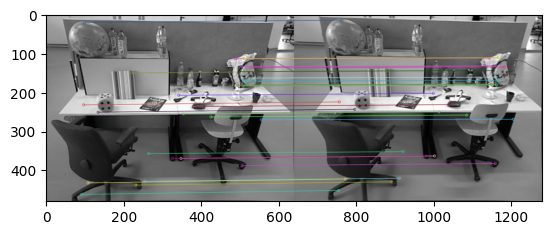

True

In [89]:
from matplotlib import pyplot as plt

# Load images 
image_one_path = "color_1.png" 
image_two_path = "color_2.png"  
img1 = cv2.imread(image_one_path, 0)  # Image 1 
img2 = cv2.imread(image_two_path, 0)  # Image 2

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)

# Sort them in ascending order of distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw first 50 matches
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:30], None, flags=2)

# Display the image
plt.imshow(img3), plt.show()

# Save the image
cv2.imwrite('matched_features.jpg', img3)


Convert 2d points in image 2 (synthesized image) into global frame

In [90]:
import numpy as np
import cv2
from scipy.spatial.transform import Rotation as R

# Define camera parameters
fx = 535.4
fy = 539.2
cx = 320.1
cy = 247.6

def pixel_to_global(x_pixel, y_pixel, pose, depth_img):
    # Get depth value at pixel coordinate
    z = depth_img[y_pixel, x_pixel]

    # Convert from pixel coordinates to camera frame
    X = (x_pixel - cx) * z / fx
    Y = (y_pixel - cy) * z / fy
    Z = z
    point_camera_frame = np.array([X, Y, Z])

    # Separate the translation and orientation (quaternion) from pose
    translation = pose[:3]
    quaternion = pose[3:]

    # Create a rotation matrix from the quaternion
    rotation_matrix = R.from_quat(quaternion).as_matrix()

    # Apply the transformation
    point_global_frame = rotation_matrix.T.dot(point_camera_frame - translation)

    return point_global_frame

# Usage:
# pose = np.array([-0.5277, 2.7277, 1.7330, 0.0105, 0.8602, -0.5092, -0.0241])
# depth_img_path = 'path_to_your_depth_image.png'
# x_pixel = 100
# y_pixel = 100
# global_point = pixel_to_global(x_pixel, y_pixel, pose, depth_img_meters_2)


In [91]:
import numpy as np
import cv2
from scipy.spatial.transform import Rotation as R

# Define camera parameters
fx = 535.4
fy = 539.2
cx = 320.1
cy = 247.6

def global_to_pixel(point_global_frame, pose):
    # Separate the translation and orientation (quaternion) from pose
    translation = pose[:3]
    quaternion = pose[3:]

    # Create a rotation matrix from the quaternion
    rotation_matrix = R.from_quat(quaternion).as_matrix()

    # Apply the transformation
    point_camera_frame = rotation_matrix.dot(point_global_frame) + translation

    # Unpack the point in camera frame
    X, Y, Z = point_camera_frame

    # Check if the point is behind the camera
    if Z <= 0:
        raise ValueError("Point is behind the camera.")

    # Convert from camera frame to pixel coordinates
    x_pixel = X * fx / Z + cx
    y_pixel = Y * fy / Z + cy

    # Round and convert to integer
    x_pixel = int(round(x_pixel))
    y_pixel = int(round(y_pixel))

    return x_pixel, y_pixel

# Usage:
# pose = np.array([-0.5277, 2.7277, 1.7330, 0.0105, 0.8602, -0.5092, -0.0241])
# point_global_frame = np.array([-1.0, -2.0, -3.0])  # Just an example
# x_pixel, y_pixel = global_to_pixel(point_global_frame, pose)
# print(x_pixel)


In [92]:
number_of_match = 30
matched_points_img2 = [kp2[match.trainIdx].pt for match in matches[:number_of_match]]
three_dim_points = []
image_2_pose = np.array([-0.5277, 2.7277, 1.7330, 0.0105, 0.8602, -0.5092, -0.0241])

for point in matched_points_img2:
    x_coord = int(round(point[0]))
    y_coord = int(round(point[1]))
    distance = depth_img_millimeters_2[y_coord, x_coord]
    a, b, c = pixel_to_global(x_coord, y_coord, image_2_pose, depth_img_meters_2)
    three_dim_points.append([a, b, c])

print(three_dim_points)

[[-5.18340405265759, -12.286861654809956, -0.7512780872673464], [-5.18340405265759, -12.286861654809956, -0.7512780872673464], [-5.640782947800234, -12.162914797879496, -0.8090138455928315], [-5.288380645146298, -12.430541324725507, -0.29790958854747185], [3.6276333320875653, -6.7311240186892025, -4.7474245461623505], [-4.991221806609972, -13.101429798671992, -0.48064081982573725], [-4.593022241348691, -8.76227118096678, -5.314749642440101], [1.2286799383122058, -7.682513004449802, -5.319708567840302], [-1.1935308154838595, -9.85271179194358, -5.532375313473519], [-5.288380645146298, -12.430541324725507, -0.29790958854747185], [-5.2542841397088615, -12.23087473016806, -1.4514868349187244], [-6.5192908535770115, -11.614656890278427, -4.1774965561716035], [-5.257981766736538, -11.999192928937836, -1.8746343099930702], [0.8171284103952058, -7.932833489753224, -5.347261853125268], [-5.257981766736538, -11.999192928937836, -1.8746343099930702], [3.7050837773077845, -7.785918243169733, -5.11

Check if coordinate is consistent (since z is negative and strange)

In [93]:
point = three_dim_points[0]
x1,y1 = global_to_pixel(point, image_2_pose)
print(x1, y1)
print(matched_points_img2[0])

521 131
(520.7979736328125, 130.94766235351562)


Batch adjustment

In [94]:
matched_points_img1 = [kp1[match.queryIdx].pt for match in matches[:number_of_match]]
two_dim_points = np.array(matched_points_img1.copy())
# print(two_dim_points)
three_dim_points = np.array(three_dim_points.copy())
# print(global_to_pixel(three_dim_points[0], image_2_pose))

image_2_pose = np.array([-0.5277, 2.7277, 1.7330, 0.0105, 0.8602, -0.5092, -0.0241])

initial_pose = image_2_pose.copy()

In [98]:
from scipy.optimize import least_squares

def project(point_global_frame, pose):
    # Separate the translation and orientation (quaternion) from pose
    translation = pose[:3]
    quaternion = pose[3:]

    # Create a rotation matrix from the quaternion
    rotation_matrix = R.from_quat(quaternion).as_matrix()

    # Apply the transformation
    point_camera_frame = rotation_matrix.dot(point_global_frame) + translation

    # Unpack the point in camera frame
    X, Y, Z = point_camera_frame

    # Check if the point is behind the camera
    # if Z <= 0:
    #     raise ValueError("Point is behind the camera.")

    # Convert from camera frame to pixel coordinates
    x_pixel = X * fx / Z + cx
    y_pixel = Y * fy / Z + cy

    return x_pixel, y_pixel

def fun(params, n, m, points_2d, points_3d):
    num_point = points_2d.shape[0]
    reprojection_error = []
    for i in range(num_point):
        projected_3d_point = project(points_3d[i], params)
        print("projected, ", projected_3d_point)
        print("2d, ", points_2d[i])
        reprojection_error.append(projected_3d_point - points_2d[i])
    reprojection_error = np.array(reprojection_error)
    return reprojection_error.ravel()
res = least_squares(fun, initial_pose, args=(2, 3, two_dim_points, three_dim_points))


projected,  (521.0, 130.99999999999994)
2d,  [505.61880493 133.06854248]
projected,  (521.0, 130.99999999999994)
2d,  [505.61880493 133.06854248]
projected,  (542.0, 134.0)
2d,  [527.5927124  135.49493408]
projected,  (526.0, 110.0)
2d,  [509.74786377 112.08995819]
projected,  (113.99999999999997, 452.0)
2d,  [ 91.16461945 462.56478882]
projected,  (504.0, 111.00000000000003)
2d,  [488.86962891 112.6828537 ]
projected,  (519.0, 383.00000000000006)
2d,  [505.6701355  388.42590332]
projected,  (251.0, 430.0)
2d,  [231.65657043 438.34262085]
projected,  (362.0, 363.0)
2d,  [347.83242798 369.41488647]
projected,  (526.0, 110.0)
2d,  [509.74786377 112.08995819]
projected,  (521.0, 160.0)
2d,  [506.11962891 162.31365967]
projected,  (565.0, 268.0)
2d,  [555.53167725 269.93304443]
projected,  (522.0, 180.0)
2d,  [507.95663452 182.41201782]
projected,  (272.0, 421.0)
2d,  [253.16925049 428.34921265]
projected,  (522.0, 180.0)
2d,  [507.95663452 182.41201782]
projected,  (132.0, 423.0)
2d,  [10

In [99]:
print('True pose: ', "-0.6360 2.7038 1.7400 0.0107 0.8598 -0.5102 -0.0168")
print('#######################################')
print('initial pose: ', initial_pose)
print('#######################################')
print('Estimated pose: ', res.x)

True pose:  -0.6360 2.7038 1.7400 0.0107 0.8598 -0.5102 -0.0168
#######################################
initial pose:  [-0.5277  2.7277  1.733   0.0105  0.8602 -0.5092 -0.0241]
#######################################
Estimated pose:  [-0.93036271  2.82963215  1.57083716 -0.08867811 -5.56428769  3.30162437
  0.17644689]
